# NEVH - Numerical Evolution from the Hamiltonian (V2)

In [3]:
import sys
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#The following line makes modules in src/ accessible from the (current) test/ dir
sys.path.append("../src")
import nevh

## Simple Harmonic Motion

In [4]:
# Hamiltonian function
def H(t, s, k, m):
    x, p = s
    return 0.5*k*x**2 + 0.5*p**2/m

In [5]:
s0 = np.array([0.5,0])   # Initial state: off equilibrium position, at rest
ds = np.ones(2)*0.1      # Integration steps parameters for partial derivatives dH/dq and dH/dp
# Hamiltonian parameters. With k=4\pi^2, m=1, the period is 1
kc = 4 * np.pi**2
mc = 1
tmin = 0; tmax = 10
G = nevh.Hgrad(H, ds, k=kc, m=mc)

In [6]:
# G is a callable object, it returns a list with the partial derivatives of the hamiltonian, in the order (and
#    with the signs) expected in hamilton's equations
print("dH/dp, -dHd/q (at q=1,p=0.5) =", G(0,[1,0.5])) #(Should display p / m, -k * q)

dH/dp, -dHd/q (at q=1,p=0.5) = [  0.5       -39.4784176]


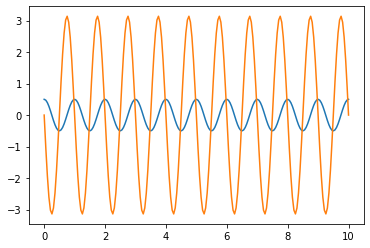

In [7]:
trj = solve_ivp(G, [tmin, tmax], s0, max_step=0.05)
plt.plot(trj.t, trj.y[0], trj.t, trj.y[1]);   # Plot of position and momentum

## Two equal coupled oscilators

Two equal masses coupled to each other and to opposing walls of a box with equal springs.

In [8]:
def H2(t, s, k, m, L):
    x1, x2, p1, p2 = s
    U = 0.5 * k * ( (x1 + L/6)**2 + (x2-x1 - L/3)**2 + (x2 - L/6)**2)
    T = 0.5 * (p1**2 + p2**2) / m
    return T + U

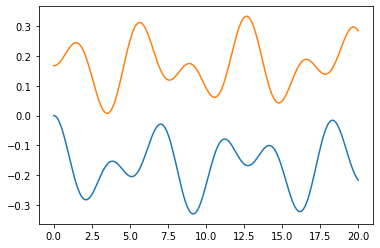

In [9]:
s0 = np.array([0, 1./6, 0., 0.])   # Initial state
ds = np.ones(4) * 0.02             # Spatial discretization step 
kc = 1.0                           # Elastic constant
mc = 1.0                           # Mass
Lc = 1.0                           # Rest separation
tmin = 0.0; tmax = 20.0
F = nevh.Hgrad(H2, ds, k=kc, m=mc, L=Lc)
T = solve_ivp(F, [tmin, tmax], s0, max_step=0.1)
plt.plot(T.t, T.y[0], T.t, T.y[1]);

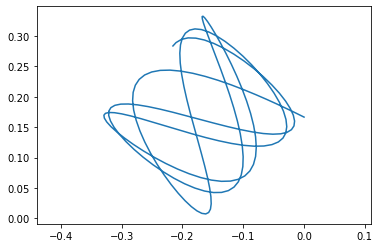

In [10]:
plt.axis("Equal")
plt.plot(T.y[0],T.y[1]); # Phase space trajectory of m1

## Elastic pendulum

In [11]:
from math import cos
def H3(t,s,m,g,l0,k):
    l, q, pl, pq = s
    T = (0.5 / m) * (pl**2 + (pq / l)**2)
    U = -m * g * l * cos(q) + 0.5 * k * (l - l0)**2
    return T + U

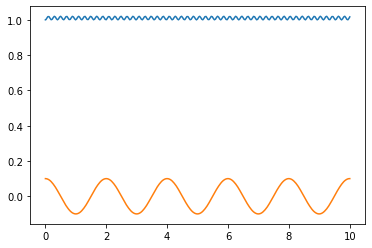

In [12]:
s0 = np.array([1.0, 0.1, 0.0, 0.0])
ds = np.ones(4)*0.1
mc = 1.0; gc = 10.0; l0c = 1.0; kc = 1000.0
F3 = nevh.Hgrad(H3, ds, k=kc, m=mc, l0=l0c, g=gc)
tmin = 0.0; tmax = 10.0
T = solve_ivp(F3, [tmin, tmax], s0, max_step=0.05)
t = T.t
l, theta = T.y[:2]
plt.plot(t, l, t, theta);


### Sun-Earth, CM frame, AU, SolarMass, year units

In [13]:
def H5(t, s, G, M, mu):
    x, y, px, py = s
    V = -G * mu * M / (np.sqrt(x**2 + y**2))
    T = 1/(2 * mu) * (px**2 + py**2)
    return T + V

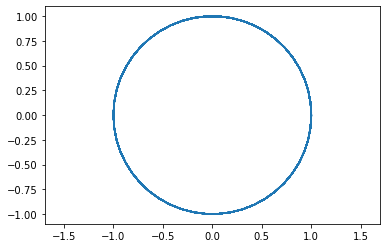

In [14]:
grav_const = 39.4905
total_mass = 1.0
reduced_mass = 3.0034E-6
r0 = 1.0
p0 = reduced_mass * (grav_const * total_mass/r0)**0.5
s0 = np.array ([r0, 0, 0, p0])
ds = np.ones(4)*0.01
F5 = nevh.Hgrad(H5, ds, G=grav_const, M=total_mass, mu=reduced_mass)
tmin = 0.0; tmax = 20
T = solve_ivp(F5, [tmin, tmax], s0, max_step=0.02)
t = T.t
x,y = T.y[:2]
plt.axis('equal')
plt.plot(x,y);

### Sun-Earth-Moon, Sun fixed, AU, SolarMass, year units

In [15]:
Ms = 1
def H6(t, s, G, m1, m2):
    x1, y1, x2, y2, px1, py1, px2, py2 = s
    V = -G * (Ms * m1 / np.sqrt(x1**2 + y1**2) + Ms * m2 / np.sqrt(x2**2 + y2**2) + 
              m1 * m2 / np.sqrt((x1-x2)**2 + (y1-y2)**2))
    T = 1/(2 * m1) * (px1**2 + py1**2) + 1/(2 * m2) * (px2**2 + py2**2)
    return T + V

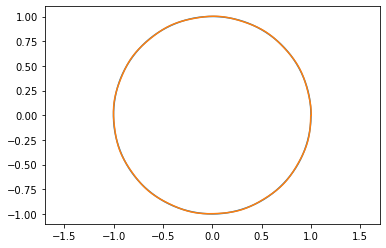

In [16]:
grav_const = 39.4905
me = 3.0034E-6
mm = 3.6923E-8
r0 = 1.0
r1 = 2.6E-3
p0 = me * (grav_const / r0)**0.5
p1 = 1*mm * (p0/me + (grav_const * me / r1)**0.5)
s0 = np.array ([r0, 0, r0+r1, 0, 0, p0, 0, p1])
ds = np.ones(8)*0.0001
F6 = nevh.Hgrad(H6, ds, G=grav_const, m1=me, m2=mm)
tmin = 0.0; tmax = 1
T = solve_ivp(F6, [tmin, tmax], s0, max_step=0.001)
t = T.t
x1,y1,x2,y2 = T.y[:4]
plt.axis('equal')
plt.plot(x1,y1,x2,y2);

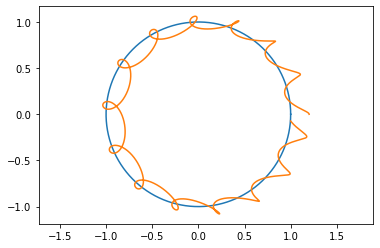

In [17]:
# Another Three Body System
grav_const = 39.4905
me = 3.0034E-1
mm = 3.6923E-7
r0 = 1.0
r1 = 1.2
p0 = me * (grav_const / r0)**0.5
p1 = 0.2*mm * (p0/me + (grav_const * me / r1)**0.5)
s0 = np.array ([r0, 0, r1, 0, 0, p0, 0, p1])
ds = np.ones(8)*0.00001
F7 = nevh.Hgrad(H6, ds, G=grav_const, m1=me, m2=mm)
tmin = 0.0; tmax = 1.
T = solve_ivp(F7, [tmin, tmax], s0, max_step=0.0005)
t = T.t
x1,y1,x2,y2 = T.y[:4]
plt.axis('equal')
plt.plot(x1,y1,x2,y2);


### Lotke-Volterra

### Double Pendulum

In [20]:
print(nevh.Hgrad.__init__.__doc__)


        Creates and inits Hgrad objects

        Parameters
        ----------
        H: function H(t, [q_1,...,q_N, p_1,...,p_N])
            Hamiltonian of physical system
        dpsi: array[2N] of floats
            step sizes for partial derivatives of hamiltonian
        hparams: array[] of floats
            parameters of the hamiltonian function

        
